# Concrete Prediction Model Prototype #2

**Purpose:** 
The aim of this notebook is to develop a supervised regression model predicting Compressive strength 28days MPa. 

**Data:** This analysis is based on a csv file containing testing data for 202 concrete samples. There were a total of 98 columns excluding the two target variables (Compressive strength 7days/28days MPa).

**Note:** 
Due to the sensitivity/privacy of this engagement, exploratory data analysis and the final features used for the project have been excluded.

**Author:** 
Adam Tassabehji

If you have any questions please do not hesitate to contact me at atassabehji@gmail.com



### Table of Contents

* [1. Importing Data and Packages](#one)
* [2. Exploratory Data Analysis](#two)
* [3. Data Cleaning](#three)
* [4. Feature Engineering](#four)
* [5. Feature Selection](#five)
* [6. Modelling](#six)
* [7. Hypertuning](#seven)
* [8. Final Results](#eight)


### 1. Importing Data and Packages  <a class="anchor" id="one"></a>

In [466]:
import pandas as pd
import numpy as np
from numpy import mean,std

from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,RepeatedKFold,learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,cross_val_score,ShuffleSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error,accuracy_score,r2_score
import itertools


from category_encoders import TargetEncoder
from sklearn.impute import KNNImputer
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SelectKBest,f_regression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,HuberRegressor, LinearRegression,LassoLarsCV
from sklearn.linear_model import LinearRegression,Ridge,Lars,TheilSenRegressor,PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression,BayesianRidge,ElasticNet
from sklearn.ensemble import StackingRegressor,VotingRegressor
from sklearn.neighbors import KNeighborsRegressor


In [467]:
#np.random.seed(0)

In [468]:
## Reading the data file
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

data=pd.read_excel('Data for trial (09-06-22).xlsx',index_col=0,na_values='-')

### 2. Exploratory Data Analysis (Private Notebook)  <a class="anchor" id="two"></a>

In [469]:
print(f'''There are a total of {data.shape[1]} columns and {data.shape[0]} rows''')

There are a total of 98 columns and 202 rows


### 3. Data Cleaning  <a class="anchor" id="three"></a>

**Identifying the Target Variable**

In [473]:
## Renaming for easier identification
data = data.rename(columns={'Concrete28 days Compressive Strength(MPa)': 'Target'})
data.columns=data.columns.str.replace(' ','_').str.replace('%','_')

**Dropping rows missing the target variable**

In [474]:
## We can't do any predictions for samples missing this information
data=data[data['Target'].notna()]

In [475]:
print(f'''There are a total of {data.shape[1]} columns and {data.shape[0]} rows''')

There are a total of 98 columns and 199 rows


**Dropping Columns that have more than 35% of missing values**

In [479]:
perc = 35.0 
min_count =  int(((100-perc)/100)*data.shape[0] + 1)
data = data.dropna( axis=1, thresh=min_count)

In [480]:
print(f'''There are a total of {data.shape[1]} columns and {data.shape[0]} rows''')

There are a total of 31 columns and 199 rows


**Dealing with Outliers**

In [481]:
## Replacing them with the 3% and 97% quantiles

cols=data.columns[data.columns!='Target']

for col in cols:
    lower=data[col].quantile(0.03)
    upper=data[col].quantile(0.97)
    data[col]=np.where(data[col] <lower, lower,data[col])
    data[col]=np.where(data[col] >upper, upper,data[col])

**Imputing Missing Values for Numerical (KNN)**

- This imputer utilizes the k-Nearest Neighbors method to replace the missing values in the datasets with the mean value from the parameter ‘n_neighbors’ nearest neighbors found. By default, it uses a Euclidean distance metric to impute the missing values. 

- In Layman's terms, for each row missing a certain value it identifies the $k$ most similar rows and imputes a value that fits.

In [482]:
data=data.reset_index(drop=True)
X=data.drop(['Target','Concrete7_days_Compressive_Strength(MPa)'],axis=1)
y=data['Target']

In [483]:
## Scaling or normalizing the data enables more accurate imputation
scaler = StandardScaler()
scaler.fit(X)
X=pd.DataFrame(scaler.transform(X),index=X.index, columns=X.columns)

>1 0.733 (0.142)
>2 0.708 (0.181)
>3 0.710 (0.194)
>4 0.711 (0.194)
>5 0.719 (0.188)
>6 0.719 (0.182)
>7 0.730 (0.142)
>8 0.737 (0.130)
>9 0.738 (0.128)
>10 0.738 (0.124)
>11 0.737 (0.123)
>12 0.735 (0.126)
>13 0.733 (0.129)
>14 0.732 (0.130)
>15 0.731 (0.130)
>16 0.729 (0.130)
>17 0.729 (0.131)
>18 0.729 (0.130)
>19 0.729 (0.132)


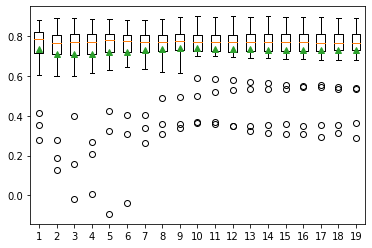

In [484]:
## Identifying optimal k
results = list()
knumbers = range(1,20)
final_results= pd.DataFrame(columns=["k","mean_r2_score"])
for k in knumbers:
    # create the modeling pipeline
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(k))), ('m', LinearRegression())])
    # evaluate the model
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(pipeline, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    # store results
    results.append(n_scores)
    print('>%s %.3f (%.3f)' % (k, mean(n_scores), std(n_scores)))
    row = {'k': k,
           'mean_r2_score': mean(n_scores)
    }

    final_results = final_results.append(row, ignore_index=True)

# plot model performance for comparison
pyplot.boxplot(results, labels=knumbers, showmeans=True)
pyplot.show()

In [485]:
k=final_results['mean_r2_score'].idxmax()+1

In [486]:
## Performing the imputation
imputer = KNNImputer(n_neighbors=k)
X = pd.DataFrame(imputer.fit_transform(X),columns = X.columns).astype(float)

### 4. Feature Engineering  <a class="anchor" id="four"></a>

**Note:**
The final model uses technical variables assembled by the client's civil engineers

Creating new variables:

- Every variable multiplied by every other variable
- Every variable divided by every other variable

In [487]:
for c1,c2 in sorted(set([tuple(sorted(s)) for s in itertools.permutations(X.columns,2)])):
    X['{0}_multiplied_{1}'.format(c1,c2)] = X[c1]*X[c2]
    X['{0}_divided_{1}'.format(c1,c2)] = X[c1]/X[c2]
    X['{1}_divided_{0}'.format(c2,c1)] = X[c2]/X[c1]
 
X=X.fillna(0)

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [488]:
print(f'Total number of features: {len(X.columns)}')

Total number of features: 841


### 5. Feature Selection  <a class="anchor" id="five"></a>

**Stepwise Forward Selection**

Forward selection is a type of stepwise regression which begins with an empty model and adds in variables one by one. In each forward step, you add the one variable that gives the single best improvement to your model. This proccess will identify and selecting the combination of variables with the highest predictive power. 

In [489]:
sfs1 = SFS(LinearRegression(),
           k_features=(2,25),
           forward=True,
           floating=True,
           cv=4,
          scoring='r2')
sfs1.fit(X, y)

SequentialFeatureSelector(cv=4, estimator=LinearRegression(), floating=True,
                          k_features=(2, 25), scoring='r2')

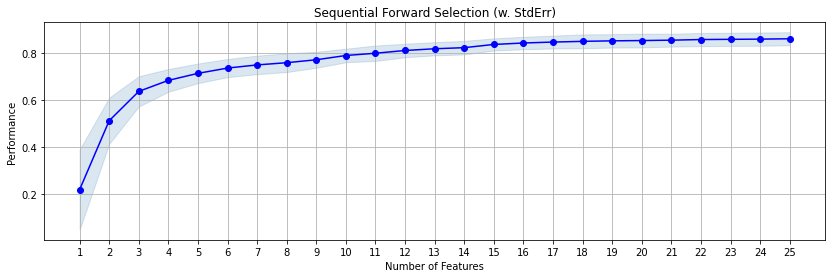

In [490]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err',figsize=(14, 4))


plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [491]:
print(f'{len(sfs1.k_feature_names_)} Features and R2 Score: {sfs1.k_score_}')

25 Features and R2 Score: 0.8621495435978149


In [492]:
## These are the variables we will select for the next stage
predictors=list(sfs1.k_feature_names_)
predictors

['Air_EntrainerQuantity_(kg/m3)_divided_Silica_FumeQuantity_(kg/m3)',
 'CementFineness(m2/kg)_divided_Coarse_Aggregate_1Loss_Angeles_Abrasion_Value_(ASTM_C131)(_)',
 'CementFineness(m2/kg)_multiplied_Coarse_Aggregate_1Specific_Gravity_SSD____________(ASTM_C127)-',
 'CementQuantity_(kg/m3)_divided_Fine/CoarseBy_mass-',
 'CementQuantity_(kg/m3)_divided_Natural_PozzolanQuantity_(kg/m3)',
 'Coarse_Aggregate_1Absorption_(ASTM_C127)(_)_multiplied_RetarderQuantity_(kg/m3)',
 'Coarse_Aggregate_1Absorption_(ASTM_C127)(_)_divided_RetarderQuantity_(kg/m3)',
 'Coarse_Aggregate_1Clay_lumps_and_friable_particles_(ASTM_C142)(_)_multiplied_Coarse_Aggregate_1Maximum_Aggregate_Size(mm)',
 'Coarse_Aggregate_1Clay_lumps_and_friable_particles_(ASTM_C142)(_)_multiplied_Fly_AshQuantity_(kg/m3)',
 'Coarse_Aggregate_1Clay_lumps_and_friable_particles_(ASTM_C142)(_)_divided_Natural_PozzolanQuantity_(kg/m3)',
 'Coarse_Aggregate_1Material_finer_than_0.075_mm_(ASTM_C117)(_)_multiplied_High_Range_Water_ReducerQuanti

In [493]:
X=X[predictors]

In [494]:
X_full_model = sm.add_constant(X)
model = sm.OLS(y,X_full_model)
result = model.fit()
result.summary()

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     61.32
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           9.64e-73
Time:                        15:06:46   Log-Likelihood:                -598.84
No. Observations:                 199   AIC:                             1250.
Df Residuals:                     173   BIC:                             1335.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================================================================================================
                                                                                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                                                       54.0876      0.638     84.757      0.000      52.828      55.347
Air_EntrainerQuantity_(kg/m3)_divided_Silica_FumeQuantity_(kg/m3)                                                                                           -1.1257      0.102    -11.006      0.000      -1.328      -0.924
CementFineness(m2/kg)_divided_Coarse_Aggregate_1Loss_Angeles_Abrasion_Value_(ASTM_C131)(_)                                                                  -0.0428      0.021     -2.051      0.042      -0.084      -0.002
CementFineness(m2/kg)_multiplied_Coarse_Aggregate_1Specific_Gravity_SSD____________(ASTM_C127)-                                                              1.1012      0.413      2.669      0.008       0.287       1.916
CementQuantity_(kg/m3)_divided_Fine/CoarseBy_mass-                                                                                                          -0.0619      0.034     -1.798      0.074      -0.130       0.006
CementQuantity_(kg/m3)_divided_Natural_PozzolanQuantity_(kg/m3)                                                                                              0.2742      0.161      1.699      0.091      -0.044       0.593
Coarse_Aggregate_1Absorption_(ASTM_C127)(_)_multiplied_RetarderQuantity_(kg/m3)                                                                              7.7687      2.271      3.421      0.001       3.286      12.251
Coarse_Aggregate_1Absorption_(ASTM_C127)(_)_divided_RetarderQuantity_(kg/m3)                                                                                -1.3379      0.240     -5.580      0.000      -1.811      -0.865
Coarse_Aggregate_1Clay_lumps_and_friable_particles_(ASTM_C142)(_)_multiplied_Coarse_Aggregate_1Maximum_Aggregate_Size(mm)                                    3.1295      0.452      6.916      0.000       2.236       4.023
Coarse_Aggregate_1Clay_lumps_and_friable_particles_(ASTM_C142)(_)_multiplied_Fly_AshQuantity_(kg/m3)                                                        -1.4635      0.499     -2.936      0.004      -2.447      -0.480
Coarse_Aggregate_1Clay_lumps_and_friable_particles_(ASTM_C142)(_)_divided_Natural_PozzolanQuantity_(kg/m3)                                                   0.0225      0.022      1.024      0.307      -0.021  

In [495]:
X=X.drop([
    'Fine_Aggregate_1Absorption____________(ASTM_C128)(_)_divided_Fine_Aggregate_1Clay_lumps_and_friable_particles_(ASTM_C142)(_)',
    'Coarse_Aggregate_1Clay_lumps_and_friable_particles_(ASTM_C142)(_)_divided_Natural_PozzolanQuantity_(kg/m3)',
    'Coarse_Aggregate_1Specific_Gravity_SSD____________(ASTM_C127)-_multiplied_Fly_AshQuantity_(kg/m3)',
    'Coarse_Aggregate_1Quantity_SSD(kg/m3)_divided_Fly_AshQuantity_(kg/m3)'],
axis=1)

**As we can see below, we were able to elimate 4 features without affecting the Adjusted R squared**

In [496]:
X_full_model = sm.add_constant(X)
model = sm.OLS(y,X_full_model)
result = model.fit()
result.summary()

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     72.75
Date:                Sun, 12 Jun 2022   Prob (F-statistic):           1.49e-75
Time:                        15:06:46   Log-Likelihood:                -601.18
No. Observations:                 199   AIC:                             1246.
Df Residuals:                     177   BIC:                             1319.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================================================================================================
                                                                                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                                                       54.2890      0.615     88.346      0.000      53.076      55.502
Air_EntrainerQuantity_(kg/m3)_divided_Silica_FumeQuantity_(kg/m3)                                                                                           -1.0927      0.095    -11.495      0.000      -1.280      -0.905
CementFineness(m2/kg)_divided_Coarse_Aggregate_1Loss_Angeles_Abrasion_Value_(ASTM_C131)(_)                                                                  -0.0507      0.020     -2.493      0.014      -0.091      -0.011
CementFineness(m2/kg)_multiplied_Coarse_Aggregate_1Specific_Gravity_SSD____________(ASTM_C127)-                                                              1.3688      0.354      3.866      0.000       0.670       2.067
CementQuantity_(kg/m3)_divided_Fine/CoarseBy_mass-                                                                                                          -0.0567      0.034     -1.681      0.095      -0.123       0.010
CementQuantity_(kg/m3)_divided_Natural_PozzolanQuantity_(kg/m3)                                                                                              0.2339      0.160      1.462      0.145      -0.082       0.549
Coarse_Aggregate_1Absorption_(ASTM_C127)(_)_multiplied_RetarderQuantity_(kg/m3)                                                                              7.5755      2.217      3.417      0.001       3.200      11.951
Coarse_Aggregate_1Absorption_(ASTM_C127)(_)_divided_RetarderQuantity_(kg/m3)                                                                                -1.3161      0.237     -5.562      0.000      -1.783      -0.849
Coarse_Aggregate_1Clay_lumps_and_friable_particles_(ASTM_C142)(_)_multiplied_Coarse_Aggregate_1Maximum_Aggregate_Size(mm)                                    3.1223      0.451      6.925      0.000       2.233       4.012
Coarse_Aggregate_1Clay_lumps_and_friable_particles_(ASTM_C142)(_)_multiplied_Fly_AshQuantity_(kg/m3)                                                        -1.3950      0.496     -2.810      0.006      -2.375      -0.415
Coarse_Aggregate_1Material_finer_than_0.075_mm_(ASTM_C117)(_)_multiplied_High_Range_Water_ReducerQuantity_(kg/m3)                                            2.2887      0.535      4.281      0.000       1.234  

## 6. Modelling<a class="anchor" id="six"></a>

**Comparison of Models**

In this portion of the notebook, we will implement a varity of different machine learning algorithms 



**LinearRegression (OLS)** fits a linear model with coefficients  to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

**Ridge regression** addresses some of the problems of Ordinary Least Squares (OLS) by imposing a penalty on the size of the coefficients. The ridge coefficients minimize a penalized residual sum of squares

**The HuberRegressor** is different to Ridge because it applies a linear loss to samples that are classified as outliers. 

**Stacking**: Uses several model outputs to build a final model for prediction

**Voting**: Uses several model outputs and decides a final prediction based on a majority vote

**Cross-validation** is a procedure used to evaluate machine learning models on a limited data sample. It's popular method because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.

**K-Fold CV** is where a given data set is split into a K number of sections/folds where each fold is used as a testing set at some point. Lets take the scenario of 5-Fold cross validation(K=5). Here, the data set is split into 5 folds. In the first iteration, the first fold is used to test the model and the rest are used to train the model. In the second iteration, 2nd fold is used as the testing set while the rest serve as the training set. This process is repeated until each fold of the 5 folds have been used as the testing set.

**K-Fold CV will be used to assess model performance** 

In [517]:
n=np.random.choice(range(1,1000))

def get_voting():
    models = list()
    models.append(('LR', LinearRegression()))
    models.append(('RID', Ridge()))
    models.append(('HUBER', HuberRegressor(max_iter=100000)))
    ensemble = VotingRegressor(estimators=models)
    return ensemble

def get_stacking():
    level0 = list()
    level0.append(('LR', LinearRegression()))
    level0.append(('RID', Ridge()))
    level0.append(('HUBER', HuberRegressor(max_iter=100000)))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

def get_models():
    models = dict()
    models['LR'] = LinearRegression()
    models['RID'] = Ridge()
    models['HUBER'] = HuberRegressor(max_iter=100000)
    models['STACK'] = get_stacking()
    models['VOTE'] = get_voting()
    return models
 
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5, n_repeats=5,random_state=n)
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    return scores


>LR 0.865 (0.026)
>RID 0.864 (0.026)
>HUBER 0.864 (0.026)
>STACK 0.860 (0.026)
>VOTE 0.865 (0.026)


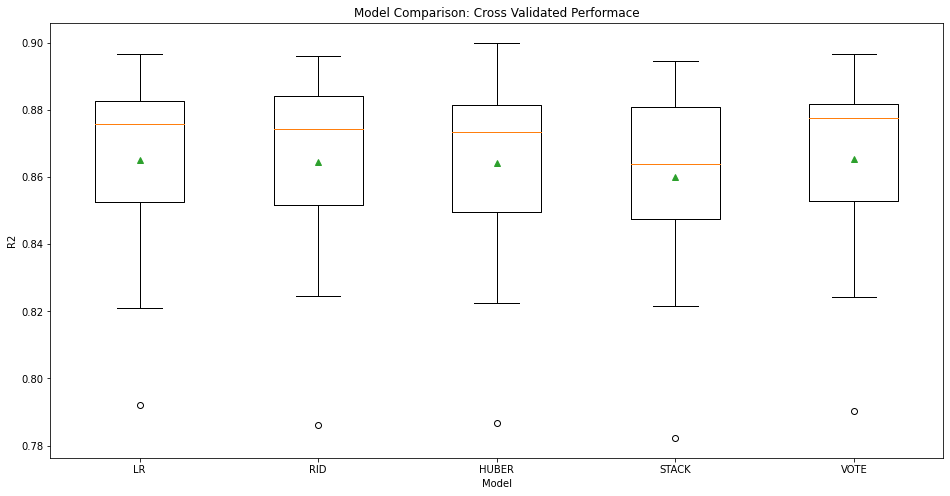

In [519]:
models = get_models()

results, names = list(), list()
df_models=pd.DataFrame(columns=['Model','Mean_R2','STDev_R2','Median_R2'])
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    
    row = {'Model': name,
           'Mean_R2': mean(scores),
           'STDev_R2': std(scores),
           'Median_R2': np.median(scores),
    }

    df_models = df_models.append(row, ignore_index=True)
    
fig= plt.figure(figsize=(16,8))

plt.title('Model Comparison: Cross Validated Performace')

plt.xlabel('Model')
plt.ylabel('R2')

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## 7. Hypertuning  <a class="anchor" id="seven"></a>

**Hypertuning** is the process of changing the algorithms standard parameters in order to optimize performance. This can be done using GridSearchCV, which builds multiple models using different combinations and implements cross validation**

**Ridge**

In [520]:
param_grid = {
    'tol':[500,150,100,50,10,5,2,1,0.01,0.001],
    'alpha':[0.01,0,25,0.5,0.75,1,1.5,2,4,5],
    'max_iter':[5,10,25,50,100]
    
}


rid1 = Ridge()

rid1grid_search = GridSearchCV(estimator = rid1,param_grid = param_grid, cv = 5 , scoring='r2', 
                              n_jobs = -1, verbose = 2)

In [521]:
rid1grid_search.fit(X, y)
rid1grid_search.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   16.7s finished


{'alpha': 0.5, 'max_iter': 5, 'tol': 500}

In [522]:
rid2 = Ridge()
rid2.set_params(**rid1grid_search.best_params_)

Ridge(alpha=0.5, max_iter=5, tol=500)

**HuberRegressor**

In [523]:
param_grid = {
    'epsilon': [1.25,1.35,1.5,1.7,2,2.35],
    'max_iter':[50,100,150],
    'alpha':[1,0.5,0.1,0.01,0.001,0.0001],
    'tol':[1e-02,1e-03,1e-04,1e-05]

}

h1 = HuberRegressor()

h1grid_search = GridSearchCV(estimator = h1,param_grid = param_grid, cv = 5 ,  scoring='r2',
                              n_jobs = -1, verbose = 2)

In [524]:
h1grid_search.fit(X, y)
h1grid_search.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 1272 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  1.3min finished
/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


{'alpha': 0.1, 'epsilon': 2.35, 'max_iter': 150, 'tol': 0.01}

In [525]:
h2 = HuberRegressor()
h2.set_params(**h1grid_search.best_params_)

HuberRegressor(alpha=0.1, epsilon=2.35, max_iter=150, tol=0.01)

## 8. Final Results  <a class="anchor" id="eight"></a>

**We will now test all models and select the one with the optimal performance**

In [526]:
def get_voting():
    models = list()
    models.append(('LR_T', LinearRegression()))
    models.append(('RID_T', rid2))
    models.append(('HUBER_T', h2))
    ensemble = VotingRegressor(estimators=models)
    return ensemble

def get_stacking():
    level0 = list()
    level0.append(('LR', LinearRegression()))
    level0.append(('RID', rid2))
    level0.append(('HUBER', h2))
    level1 = LinearRegression()
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

def get_models():
    models = dict()
    models['LR'] = LinearRegression()
    models['RID_T'] = rid2
    models['HUBER_T'] = h2
    models['STACK_T'] = get_stacking()
    models['VOTE_T'] = get_voting()
    return models
 
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5, n_repeats=5,random_state=n)
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    return scores


>LR 0.865 (0.026)
>RID_T 0.865 (0.026)
>HUBER_T 0.865 (0.025)
>STACK_T 0.859 (0.028)
>VOTE_T 0.865 (0.026)


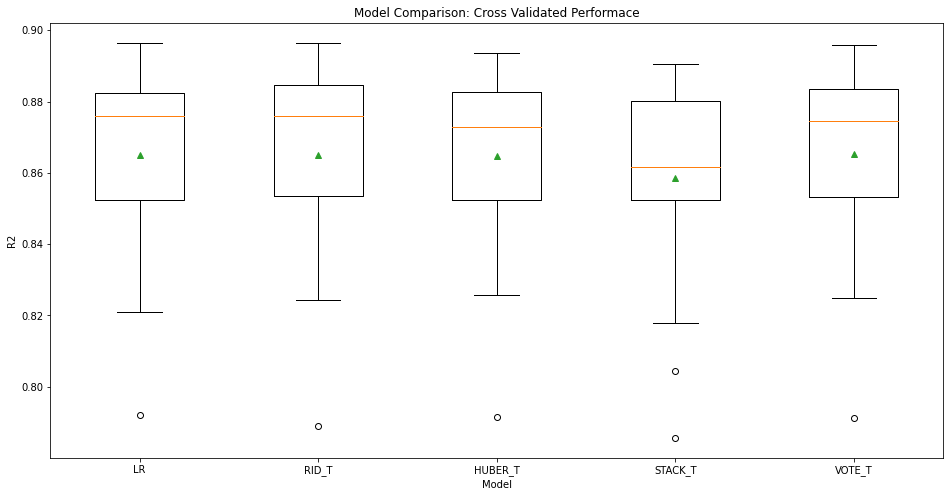

In [527]:
models = get_models()

results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    
    row = {'Model': name,
           'Mean_R2': mean(scores),
           'STDev_R2': std(scores),
           'Median_R2':np.median(scores)
    }

    df_models = df_models.append(row, ignore_index=True)
    
fig= plt.figure(figsize=(16,8))

plt.title('Model Comparison: Cross Validated Performace')

plt.xlabel('Model')
plt.ylabel('R2')

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [528]:
df_models=df_models.sort_values('Median_R2',ascending=False)

In [529]:
df_models

,Model,Mean_R2,STDev_R2,Median_R2
4,VOTE,0.865348,0.025838,0.877555
0,LR,0.864959,0.026006,0.875897
5,LR,0.864959,0.026006,0.875897
6,RID_T,0.864933,0.026016,0.875829
9,VOTE_T,0.865212,0.025572,0.874470
1,RID,0.864462,0.026244,0.874289
2,HUBER,0.864163,0.026355,0.873280
7,HUBER_T,0.864675,0.024978,0.872780
3,STACK,0.860052,0.026269,0.863887
8,STACK_T,0.858625,0.028062,0.861713


In [530]:
print(f'''

The best performing model is {df_models.iloc[0,0]} 

Median R2: {round(df_models.iloc[0,-1],3)} 

Mean R2: {round(df_models.iloc[0,1],3)} 

Standard Deviation of R2: {round(df_models.iloc[0,2],3)} 


''')



The best performing model is VOTE 

Median R2: 0.878 

Mean R2: 0.865 

Standard Deviation of R2: 0.026 





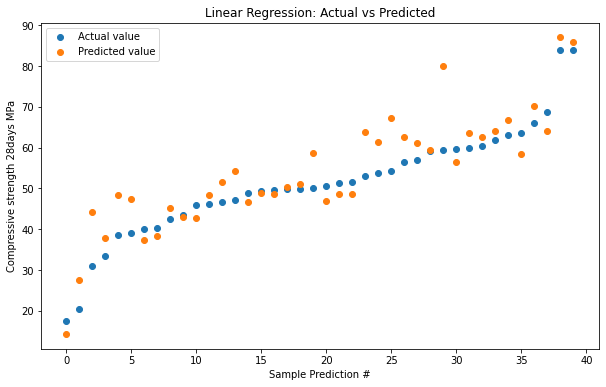

In [531]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

lr=LinearRegression()

model = lr.fit(X_train, y_train)
y_pred = model.predict(X_test)

test=pd.DataFrame({'Actual value': y_test,'Predicted value': y_pred}).sort_values('Actual value').reset_index()


plt.figure(figsize=(10, 6))

plt.title("Linear Regression: Actual vs Predicted")

plt.scatter(test.index, test['Actual value'], label='Actual')

plt.scatter(test.index, test['Predicted value'], label='Predicted')

plt.xlabel("Sample Prediction #")

plt.ylabel("Compressive strength 28days MPa")

plt.legend(['Actual value','Predicted value'])